In [ ]:
import sys, os
from google.colab import drive

In [ ]:
#Mount Drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Test/MultilayerPerceptronFS/")
data_path= "/content/drive/My Drive/Test/MultilayerPerceptronFS/data/flowers"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from data.ImageLoader import getImages, convertToGrayscale, preprocessImage
from MLP.MLP import Dense, ActivationSoftmax, CategoricalCrossEntropyLoss, Backpropagation, ActivationReLU, ActivationSigmoid

# Load and Pre-process data

In [ ]:
labels = ['Sunflower', 'Dandelion', 'Rose']
n_data = 100

X = None
y = None
for i in range(len(labels)):
    if(X is None):
        X = getImages(labels[i], n=n_data)
    else:
        X = np.append(X, getImages(labels[i], n=n_data), axis=0)

    if(y is None):
        y = np.full(shape=n_data,fill_value=i,dtype=np.int)
    else:
        y = np.append(y, np.full(shape=n_data,fill_value=i,dtype=np.int), axis=0)

print(X.shape)
X = convertToGrayscale(X)
print(X.shape)
X = preprocessImage(X)
print(X.shape)

(300, 240, 320, 3)
(300, 240, 320)
(300, 76800)


In [ ]:
# Change from sparse into one hot encoding
n_values = np.max(y) + 1
y = np.eye(n_values)[y]
print(y.shape)

(300, 3)


In [ ]:
# Change from sparse into one hot encoding
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# Probabilities in each class
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

[80. 80. 80.]
[20. 20. 20.]


In [ ]:
def accuracy(y_prob, y_true):
    return (prediction(y_prob) == np.argmax(y_true, axis=-1)).mean()

def prediction(y_prob):
    return np.argmax(y_prob, axis=-1)

# Dense Model

In [ ]:
class BinaryCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples

In [ ]:
# Hyperparameter
batch_size = 5
learning_rate = 0.1
epochs = 50

In [ ]:
# Create Layer
# input shape = (600, 76800)
# hidden layer [64, 128, 256, 512, 1024]
# output shape = (,3)
def create_model(hidden_layer_n):
  dense_0 = Dense(76800, hidden_layer_n)
  activation0 = ActivationSigmoid()
  dense_1 = Dense(hidden_layer_n, 3)
  activation1 = ActivationSigmoid()
  CELoss = BinaryCrossEntropyLoss()
  return [dense_0, activation0, dense_1, activation1, CELoss]

In [ ]:
def fit(x_train, y_train, lr):
  backprop = Backpropagation(lr)
  epochs = 50
  loss = []
  acc = []

  n_data = len(x_train)
  n_batch = n_data//batch_size

  remainder = n_data%batch_size
  if(remainder!=0):
      n_batch += 1

  for _ in tqdm(range(epochs), leave=False):
      batch_loss = []
      batch_acc = []

      for i in tqdm(range(n_batch), leave=False):
          #if batch can not be equally divided
          #batch all of the remainder data
          if(i*batch_size+batch_size>n_data):
              x_batch = x_train[i*batch_size:]
              y_batch = y_train[i*batch_size:]
          else:
              x_batch = x_train[i*batch_size: (i+1) *batch_size]
              y_batch = y_train[i*batch_size: (i+1) *batch_size]

          #Forward pass
          dense_0.forward(x_batch)
          activation0.forward(dense_0.output)
          dense_1.forward(activation0.output)
          activation1.forward(dense_1.output)

          #Backward pass
          CELoss.backward(activation1.output, y_batch)
          dense_1.backward(CELoss.dinputs)
          activation0.backward(dense_1.dinputs)
          dense_0.backward(activation0.dinputs)

          #Update Weight
          backprop.updateParams(dense_1)
          backprop.updateParams(dense_0)

          #Calculate Metrics/ batch
          batch_acc.append(accuracy(activation1.output, y_batch))
          batch_loss.append(CELoss.forward(activation1.output, y_batch))
      
      acc.append(np.mean(batch_acc))
      loss.append((np.sum(batch_loss[:n_batch-1])+np.sum(batch_loss[n_batch-1]))/ n_data)
      print("Accuracy:",acc[-1])
      print("Entropy Loss:",loss[-1])
  return acc, loss

In [ ]:
def predict(X):
    dense_0.forward(X)
    activation0.forward(dense_0.output)
    dense_1.forward(activation0.output)
    activation1.forward(dense_1.output)

    return prediction(activation1.output)

In [73]:
def test(X_test , y_test):
  dense_0.forward(X_test)
  activation0.forward(dense_0.output)
  dense_1.forward(activation0.output)
  activation1.forward(dense_1.output)

  acc = accuracy(activation1.output , y_test)
  loss = np.mean(CELoss.forward(activation1.output , y_test))
  return acc , loss

### n hidden layer = 16

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(16)
acc_16, loss_16 = fit(X_train, y_train, 0.1)

Accuracy: 0.32083333333333336
Entropy Loss: 0.7042469717483858


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


Accuracy: 0.32083333333333336
Entropy Loss: 0.702727175873149


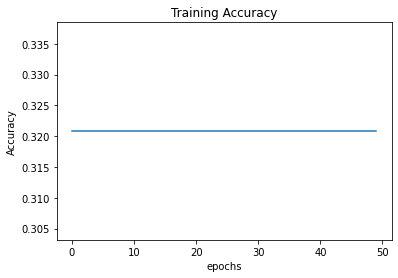

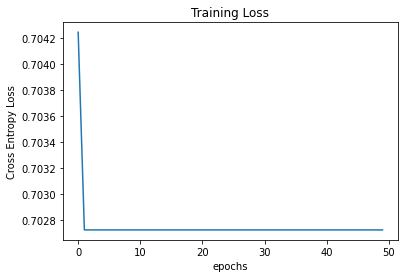

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_16)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_16)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


### n hidden layer = 64

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(64)
acc_64, loss_64 = fit(X_train, y_train, 0.1)

/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


Accuracy: 0.30833333333333335
Entropy Loss: 7.180609470489279


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3333333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.3208333333333333
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


Accuracy: 0.31666666666666665
Entropy Loss: 7.432233048618804


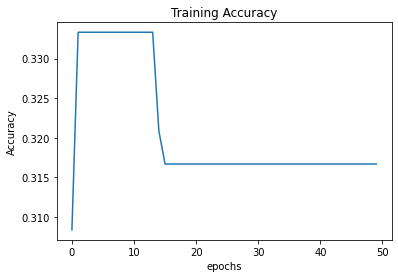

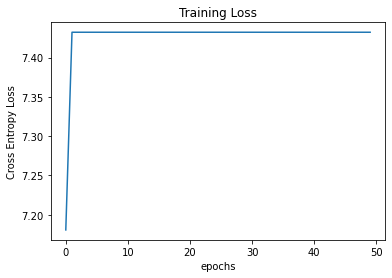

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_64)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_64)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


### n hidden layer = 256

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(256)
acc_256, loss_256 = fit(X_train, y_train, 0.1)

/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


Accuracy: 0.32916666666666666
Entropy Loss: 6.905701953132382


Accuracy: 0.3458333333333334
Entropy Loss: 6.984508172195985


Accuracy: 0.325
Entropy Loss: 6.984508172195985


Accuracy: 0.325
Entropy Loss: 6.984508172195985


Accuracy: 0.325
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3583333333333334
Entropy Loss: 7.172166476155548


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


Accuracy: 0.33749999999999997
Entropy Loss: 7.297915585691958


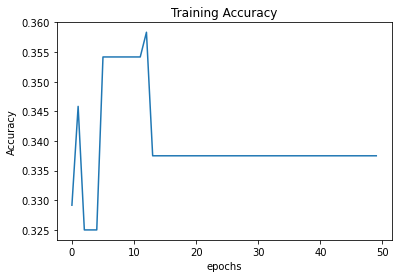

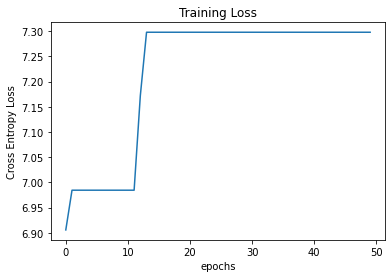

In [ ]:
plt.plot(acc_256)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_256)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


### n hidden layer = 1024

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(1024)
acc_1024, loss_1024 = fit(X_train, y_train, 0.1)

/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


Accuracy: 0.3458333333333334
Entropy Loss: 6.965988239488993


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


Accuracy: 0.3541666666666667
Entropy Loss: 6.984508172195985


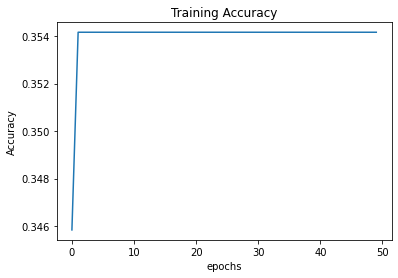

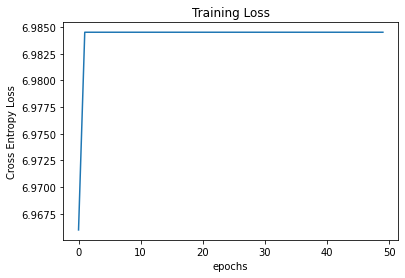

In [ ]:
plt.plot(acc_1024)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_1024)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


### n hidden layer = 16, lr = 0.8

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(16)
acc_16_8, loss_16_8 = fit(X_train, y_train, 0.8)

/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


Accuracy: 0.3500000000000001
Entropy Loss: 6.662628781277606


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.325
Entropy Loss: 7.208370610407394


Accuracy: 0.325
Entropy Loss: 7.208370610407394


Accuracy: 0.325
Entropy Loss: 7.208370610407394


Accuracy: 0.325
Entropy Loss: 7.208370610407394


Accuracy: 0.325
Entropy Loss: 7.208370610407394


Accuracy: 0.29583333333333334
Entropy Loss: 7.208120040726947


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


Accuracy: 0.3
Entropy Loss: 7.208370610407394


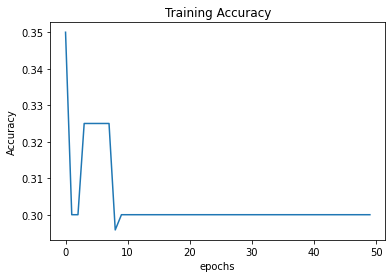

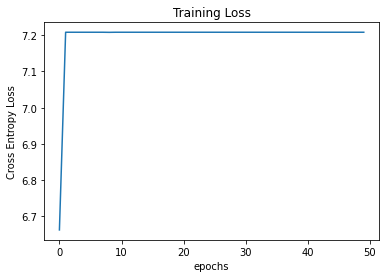

In [ ]:
plt.plot(acc_16_8)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_16_8)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


/content/drive/My Drive/Test/MultilayerPerceptronFS/MLP/MLP.py:21: RuntimeWarning: overflow encountered in exp
  self.output = 1/ (1+np.exp(-inputs))


### n hidden layer = 16, lr = 0.01

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(16)
acc_16_e2, loss_16_e2 = fit(X_train, y_train, 0.01)

Accuracy: 0.29583333333333334
Entropy Loss: 0.6559699340782951


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422593771033642


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422337249500935


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422352176925589


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353203365475


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353266859689


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353270754301


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353270992445


Accuracy: 0.30833333333333335
Entropy Loss: 0.642235327100697


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007853


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007907


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.642235327100791


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.642235327100791


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.642235327100791


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.642235327100791


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


Accuracy: 0.30833333333333335
Entropy Loss: 0.6422353271007909


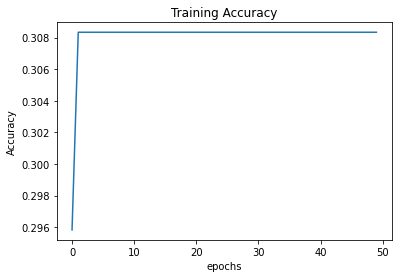

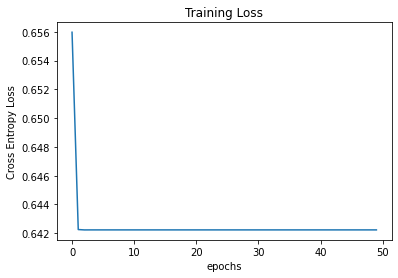

In [ ]:
plt.plot(acc_16_e2)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_16_e2)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333


### n hidden layer = 16, lr = 0.001

In [ ]:
[dense_0, activation0, dense_1, activation1, CELoss] = create_model(16)
acc_16_e3, loss_16_e3 = fit(X_train, y_train, 0.001)

Accuracy: 0.2583333333333333
Entropy Loss: 0.6930127531625546


Accuracy: 0.2583333333333333
Entropy Loss: 0.6698804630784779


Accuracy: 0.24583333333333335
Entropy Loss: 0.6563501498322314


Accuracy: 0.2708333333333333
Entropy Loss: 0.6483989193663489


Accuracy: 0.2791666666666667
Entropy Loss: 0.643722821714665


Accuracy: 0.2625
Entropy Loss: 0.6409759325661681


Accuracy: 0.26666666666666666
Entropy Loss: 0.639365383375808


Accuracy: 0.26666666666666666
Entropy Loss: 0.6384230556204646


Accuracy: 0.2708333333333333
Entropy Loss: 0.6378727936555578


Accuracy: 0.2708333333333333
Entropy Loss: 0.6375520384347294


Accuracy: 0.2708333333333333
Entropy Loss: 0.6373653464217864


Accuracy: 0.2708333333333333
Entropy Loss: 0.6372568212908274


Accuracy: 0.2708333333333333
Entropy Loss: 0.637193801547322


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371572391716672


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371360432224248


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371237642897357


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371166559956517


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371125439959731


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371101672351309


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371087947856825


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371080032235363


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371075473893912


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371072854147192


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371071352522774


Accuracy: 0.2708333333333333
Entropy Loss: 0.63710704948474


Accuracy: 0.2708333333333333
Entropy Loss: 0.637107000731973


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069732011839


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069577960379


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069492869913


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069446749927


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069422458537


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069410241914


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069404584201


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069402392731


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069401954325


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069402336446


Accuracy: 0.2708333333333333
Entropy Loss: 0.637106940304467


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069403827608


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069404566423


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069405212771


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069405754345


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069406196023


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069406549821


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069406829737


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407049269


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407220362


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407353089


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407455702


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407534836


Accuracy: 0.2708333333333333
Entropy Loss: 0.6371069407595747


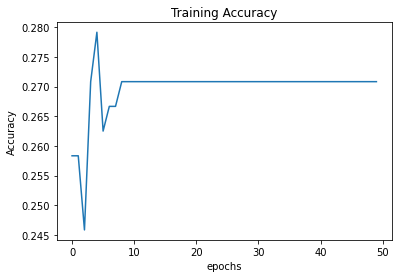

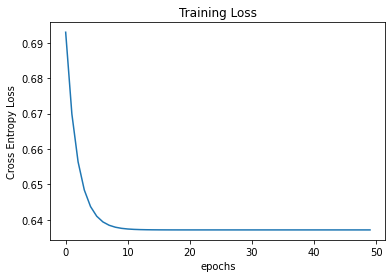

In [ ]:
plt.plot(acc_16_e3)
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(loss_16_e3)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
acc, loss = test(X_test, y_test)

print(acc)

0.3333333333333333
